In [1]:
%matplotlib widget
from datetime import datetime, timedelta
import glob
from eigsep_corr import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates

In [2]:
DATA_DIR = "/home/christian/Documents/research/eigsep/data-analysis/data/deployment3"
files = sorted(glob.glob(f"{DATA_DIR}/*"))
files = np.array(files)
print(len(files))
hdr = io.read_header(files[0])
print(io.read_header(files[0]).keys())
hdr, data = io.read_file(files[0], header=hdr)
print(data.keys())
print(data['0'].shape)
freqs = hdr["freqs"] / 1e6

1800
dict_keys(['dtype', 'infochan', 'nchan', 'acc_bins', 'fpg_file', 'fpg_version', 'sample_rate', 'gain', 'corr_acc_len', 'corr_scalar', 'pol01_delay', 'pol23_delay', 'pol45_delay', 'pam_atten', 'fft_shift', 'pairs', 'acc_cnt', 'sync_time', 'header_size', 'data_start', 'filename', 'filesize', 'nspec', 'freqs', 'dfreq', 'inttime', 'times'])
dict_keys(['0', '1', '2', '3', '4', '5', '02', '04', '24', '13', '15', '35'])
(60, 2, 1024, 1)


Antennas:\
0, 1: north antenna \
2, 3: south antenna \
4, 5: lifted antenna

Even numbers are North polarization, odd numbers are East

In [3]:
# keys are (antenna, polarization)
ant_keys = {"0": ("north", "north"), "1": ("north", "east"), "2": ("south", "north"), "3": ("south", "east"), "4": ("elev", "north"), "5": ("elev", "east")}
inv_ant_keys = {"north": {"north": "0", "east": "1"}, "south": {"north": "2", "east": "3"}, "elev": {"north": "4", "east": "5"}}

auto = [f"{i}" for i in range(6)]
cross = [f"{i}{i+2}" for i in range(4)] + ["04", "15"]

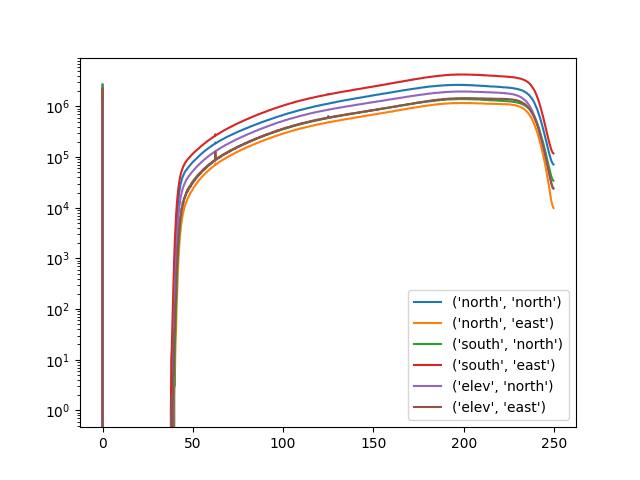

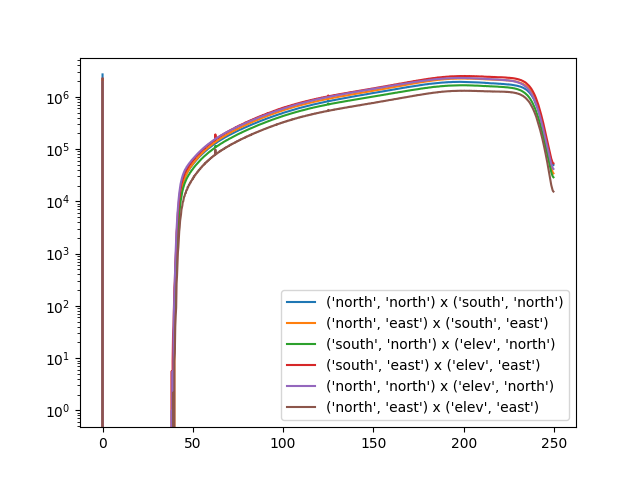

In [4]:
# load measurments
_load_data = np.load("/home/christian/Documents/research/eigsep/eigsep_cal/gain_calibration/data/field_oct24/ants_load.npz", allow_pickle=True)
load_data = {}
for ant in _load_data:
    for pol in ["north", "east"]:
        k = inv_ant_keys[ant][pol]
        load_data[k] = _load_data[ant][()][pol]

plt.figure()
for a in auto:
    plt.plot(freqs, load_data[a], label=f"{ant_keys[a]}")
plt.legend()
plt.yscale("log")
plt.show()

# cross correlations
for pair in cross:
    x = 1
    for k in pair:
        x *= np.sqrt(load_data[k])
    load_data[pair] = x

plt.figure()
for x in cross:
    plt.plot(freqs, load_data[x], label=f"{ant_keys[x[0]]} x {ant_keys[x[1]]}")
plt.legend()
plt.yscale("log")
plt.show()

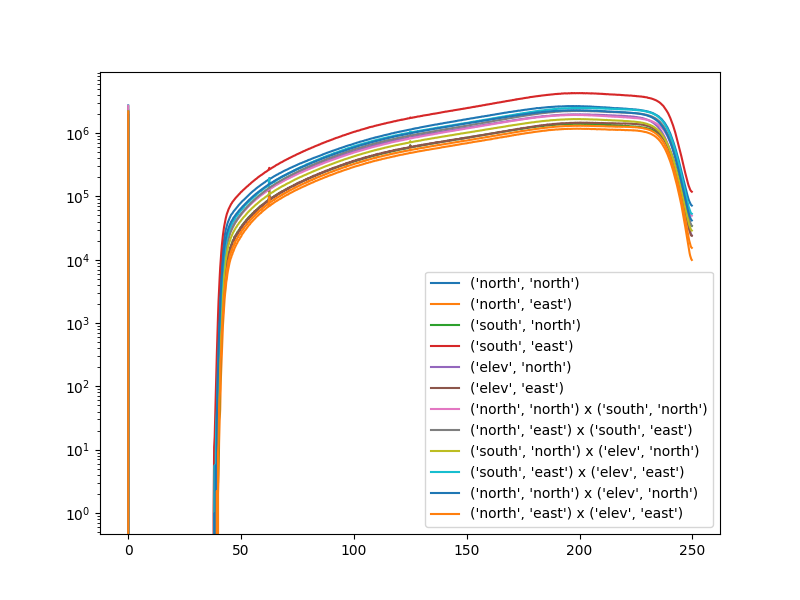

In [5]:
plt.figure(figsize=(8, 6))
for a in auto:
    plt.plot(freqs, load_data[a], label=f"{ant_keys[a]}")
for x in cross:
    plt.plot(freqs, load_data[x], label=f"{ant_keys[x[0]]} x {ant_keys[x[1]]}")
plt.legend()
plt.yscale("log")
plt.show()

In [6]:
lift_win = (950, 1180)

def read_data(window=lift_win, pairs=auto+cross, gain_normalize=True):
    mn, mx = window
    data = {}
    sync_time = None
    acc_cnt = []
    times = []
    for f in files[mn:mx]:
        hdr, dat = io.read_file(f)
        if sync_time is None or hdr["sync_time"] != sync_time:
            print(f, sync_time, hdr["sync_time"])
            sync_time = hdr["sync_time"]
        times.append(hdr["times"])
        acc_cnt.append(hdr["acc_cnt"])
        for k, d in dat.items():
            if k not in pairs:
                continue
            if len(k) == 1:
                d.dtype = io.build_dtype(*hdr["dtype"])
                d = d[..., 0]  # only real part
            else:
                d = d[..., 0] + 1j * d[..., 1]  # complex number
            data[k] = data.get(k, []) + [d]
    for k, v in data.items():
        _data = np.concatenate(v, axis=0)
        if gain_normalize:
            _data = _data / load_data[k]
        data[k] = _data
    #tmin, tmax = ftime[mn], ftime[mx]
    acc_cnt = np.array(acc_cnt)
    times = np.array(times)
    times += 3600  # pacific time to utah time
    return data, hdr, acc_cnt, times#, (tmin, tmax)

data, hdr, acc_cnt, times = read_data(lift_win, pairs=["2", "3", "4", "5", "24", "35"])
print(np.all(np.diff(acc_cnt.ravel()) == 1))  # continuous times
print(np.sort(np.diff(acc_cnt.ravel())))

/home/christian/Documents/research/eigsep/data-analysis/data/deployment3/20241020_103004.eig None 1729441860.6774528


/tmp/ipykernel_294701/1645860203.py:28: RuntimeWarning: divide by zero encountered in divide
  _data = _data / load_data[k]
/tmp/ipykernel_294701/1645860203.py:28: RuntimeWarning: invalid value encountered in divide
  _data = _data / load_data[k]


False


/tmp/ipykernel_294701/606304955.py:15: RuntimeWarning: invalid value encountered in add
  cross = 1/2 * (data[k][:, 0] + data[k][:, 1])
/tmp/ipykernel_294701/606304955.py:15: RuntimeWarning: invalid value encountered in multiply
  cross = 1/2 * (data[k][:, 0] + data[k][:, 1])


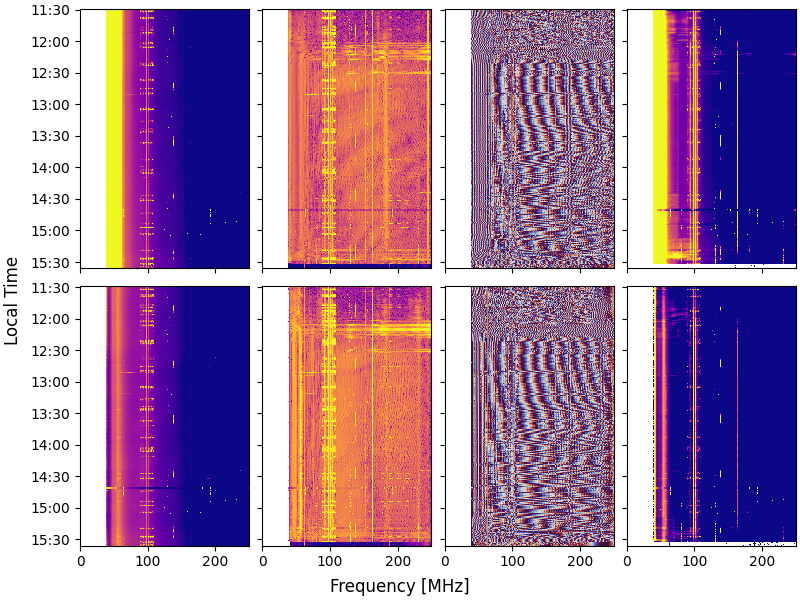

In [10]:
def plot_waterfall(data, times, freqs, title=None):
    fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=4, sharex=True, sharey=True, constrained_layout=True)
    auto_ln = colors.LogNorm(vmin=1, vmax=10)
    cross_ln = colors.LogNorm(vmin=1e-4, vmax=1e-1)
    tmin = datetime.fromtimestamp(times.ravel()[0])
    tmax = datetime.fromtimestamp(times.ravel()[-1])
    extent = [freqs.min(), freqs.max(), tmax, tmin]
    kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
    for i, k in enumerate(["24", "35"]):
        autos = {}
        for j in range(2):
            autos[j] = 1/2 * (data[k[j]][:, 0] + data[k[j]][:, 1])
            axs[i, 3*j].imshow(np.abs(autos[j]), norm=auto_ln, **kwargs)
        norm = np.sqrt(autos[0]**2 + autos[1]**2)
        cross = 1/2 * (data[k][:, 0] + data[k][:, 1])
        axs[i, 1].imshow(np.abs(cross)/norm, norm=cross_ln, **kwargs)
        axs[i, 2].imshow(np.angle(cross), aspect="auto", cmap="twilight", extent=extent, interpolation="none", vmin=-np.pi, vmax=np.pi)
    axs[0, 0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig.supxlabel("Frequency [MHz]")
    fig.supylabel("Local Time")
    if title:
        plt.suptitle(title)
    plt.show()
    
plot_waterfall(data, times, freqs)

In [34]:
tstart = "2024-10-20 13:40"
tend = "2024-10-20 13:50"
tstart = datetime.fromisoformat(tstart).timestamp()
tend = datetime.fromisoformat(tend).timestamp()
print(tstart, tend)

1729456800.0 1729457400.0


In [39]:
trav = times.ravel()
tcut = (trav > tstart) & (trav < tend)

d2 = data["2"][tcut].mean(axis=1)
d24 = data["24"][tcut].mean(axis=1)
d4 = data["4"][tcut].mean(axis=1)

/home/christian/Documents/research/eigsep/data-analysis/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/christian/Documents/research/eigsep/data-analysis/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


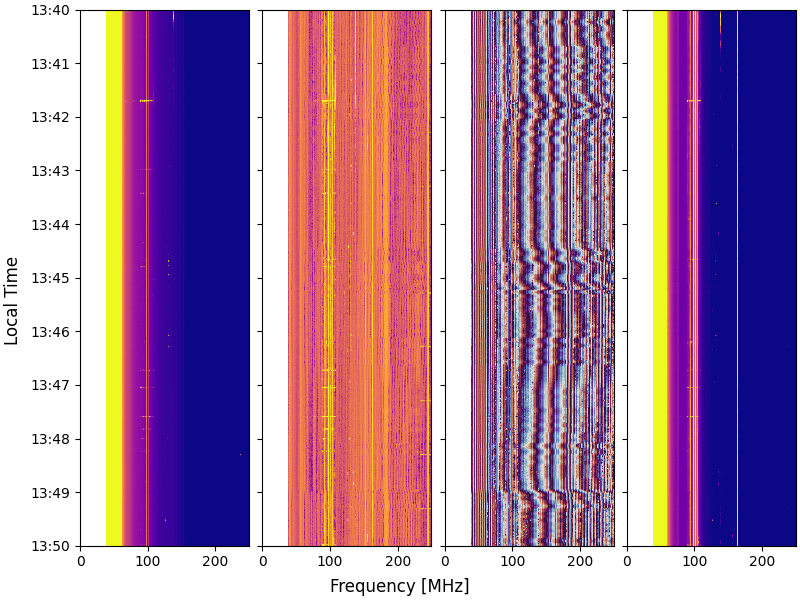

In [40]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=1, ncols=4, sharex=True, sharey=True, constrained_layout=True)
auto_ln = colors.LogNorm(vmin=1, vmax=10)
cross_ln = colors.LogNorm(vmin=1e-4, vmax=1e-1)
tmin = datetime.fromtimestamp(tstart)
tmax = datetime.fromtimestamp(tend)
extent = [freqs.min(), freqs.max(), tmax, tmin]
kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
axs[0].imshow(np.abs(d2), norm=auto_ln, **kwargs)
axs[-1].imshow(np.abs(d4), norm=auto_ln, **kwargs)
norm = np.sqrt(d2**2 + d4**2)
cross = d24
axs[1].imshow(np.abs(cross)/norm, norm=cross_ln, **kwargs)
axs[2].imshow(np.angle(cross), aspect="auto", cmap="twilight", extent=extent, interpolation="none", vmin=-np.pi, vmax=np.pi)
axs[0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.supxlabel("Frequency [MHz]")
fig.supylabel("Local Time")
plt.show()

In [41]:
d2.shape

(559, 1024)

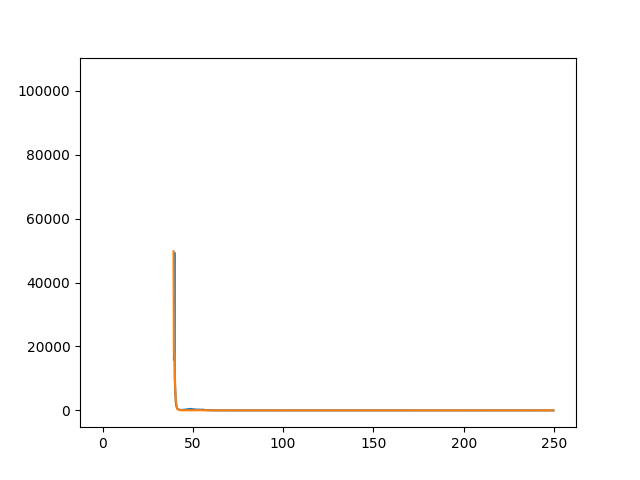

In [42]:
plt.figure()
plt.plot(freqs, d2.mean(axis=0))
plt.plot(freqs, d4.mean(axis=0))
plt.show()

/home/christian/Documents/research/eigsep/data-analysis/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/christian/Documents/research/eigsep/data-analysis/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


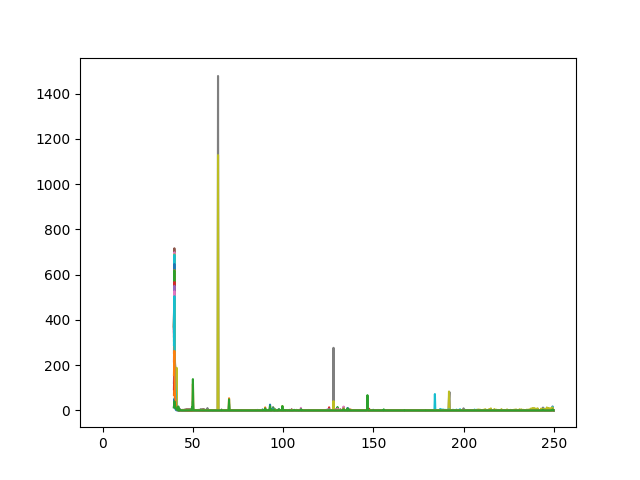

In [8]:
d24_avg = data["24"].mean(axis=1)
d24_avg.shape = (23, 600, 1024)
d24_avg = np.abs(d24_avg.mean(axis=1))

plt.figure()
plt.plot(freqs, d24_avg.T)
plt.show()

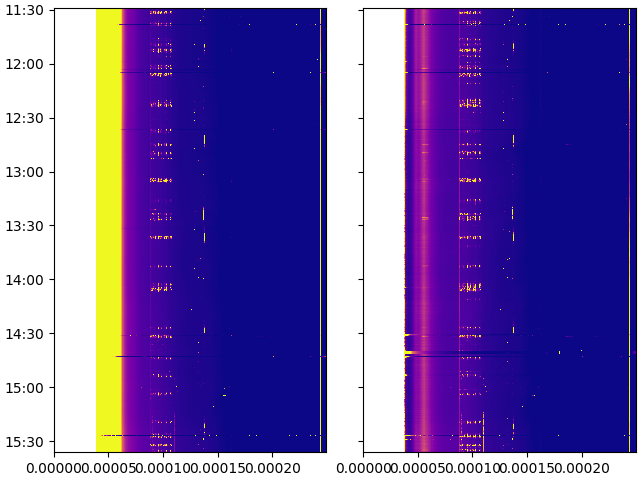

In [9]:
extent = [freqs.min()/1e6, freqs.max()/1e6, datetime.fromtimestamp(times.ravel()[-1]), datetime.fromtimestamp(times.ravel()[0])]
fig, axs = plt.subplots(ncols=2, constrained_layout=True, sharex=True, sharey=True)
for i, k in enumerate(["2", "3"]):
    auto = 1/2 * (data[k][:, 0] + data[k][:, 1])
    #auto = auto / data[k].mean() * data["5"].mean()
    axs[i].imshow(auto, aspect="auto", interpolation="none", extent=extent, cmap="plasma", vmin=1e0, vmax=1e1)
axs[0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()